In [1]:
%pylab inline
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq
from time import time

fontsize = 20

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def parametric_burgers_rhs(u, t, params):
    k,a,b,c = params
    deriv = a*(1+c*np.sin(t))*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u))
    return real(deriv)

In [3]:
# Set size of grid
n = 256
m = 256

# Set up grid
x = np.linspace(-8,8,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,10,m);          dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x+1)**2)

# Solve with time dependent uu_x term
params = (k, -1, 0.1, 0.25)
u = odeint(parametric_burgers_rhs, u0, t, args=(params,)).T

u_xx_true = 0.1*np.ones(m)
uu_x_true = -1*(1+0.25*np.sin(t))

/tmp/ipykernel_45236/2475514383.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(X, T, u.T, cmap=cm.coolwarm)


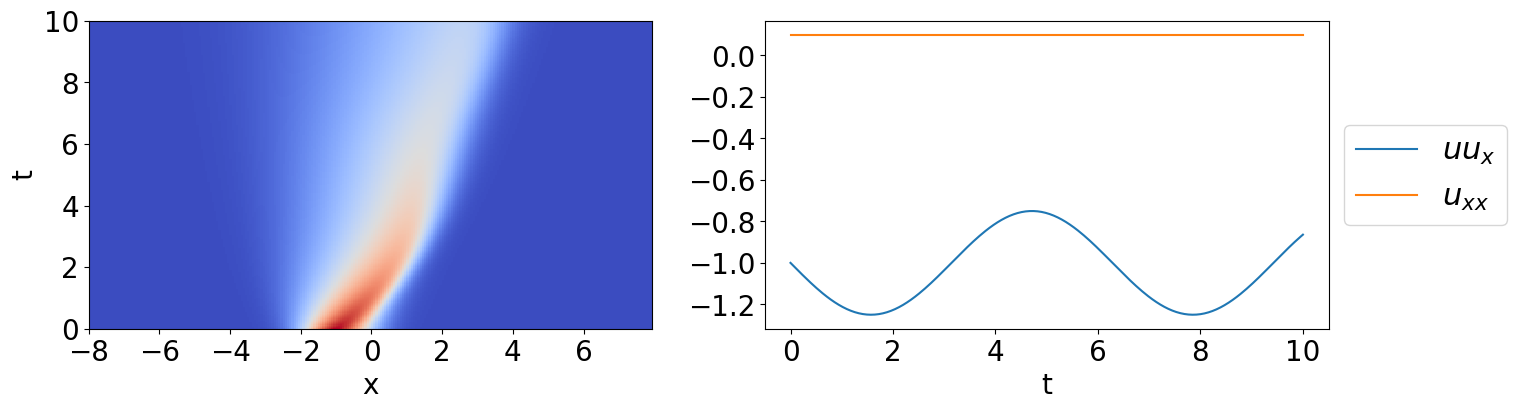

In [4]:
# Plot
fig=figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(t, uu_x_true, label=r'$uu_{x}$')
plot(t, u_xx_true, label=r'$u_{xx}$')

xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel('t', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [4]:
Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'FD')

In [25]:
print(Ut.shape, Theta.shape, len(rhs_des))
print(rhs_des)
Theta_grouped = [real(Theta[j*n:(j+1)*n,:]) for j in range(m)]
Ut_grouped = [real(Ut[j*n:(j+1)*n]) for j in range(m)]

(65536, 1) (65536, 20) 20
['', 'u', 'u^2', 'u^3', 'u_{x}', 'uu_{x}', 'u^2u_{x}', 'u^3u_{x}', 'u_{xx}', 'uu_{xx}', 'u^2u_{xx}', 'u^3u_{xx}', 'u_{xxx}', 'uu_{xxx}', 'u^2u_{xxx}', 'u^3u_{xxx}', 'u_{xxxx}', 'uu_{xxxx}', 'u^2u_{xxxx}', 'u^3u_{xxxx}']


/home/yifan/Documents/code_equation_learn/Experiments/parametric_pde_find.py:601: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), normalize)
/home/yifan/Documents/code_equation_learn/Experiments/parametric_pde_find.py:571: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W[biginds,i] = np.linalg.lstsq(Xs[i][:, biginds],ys[i])[0].reshape(len(biginds))


MSE:  3.9477204423052233e-07


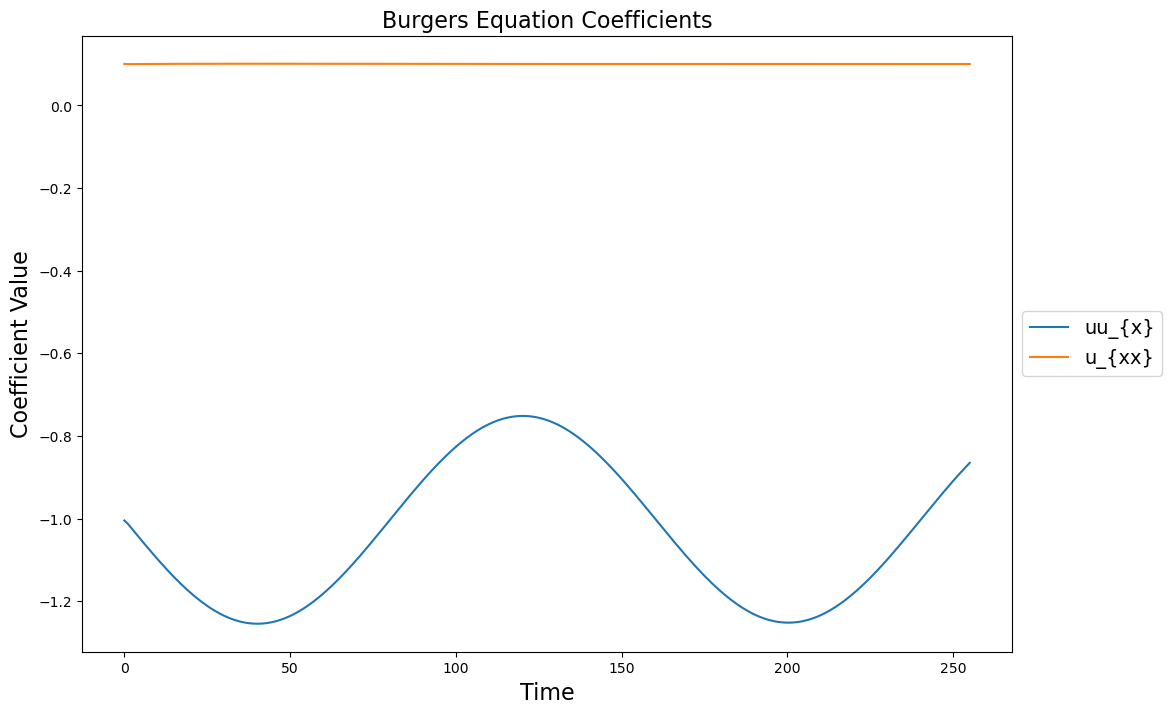

In [6]:
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        plot(xi[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

i_uu_x = [i for i in range(len(rhs_des)) if rhs_des[i] == 'uu_{x}'][0]
i_u_xx = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u_{xx}'][0]
xi_true = np.zeros(xi.shape)
xi_true[i_uu_x] = uu_x_true
xi_true[i_u_xx] = u_xx_true
mse_clean_sgtr = Norm(xi-xi_true)**2/(m*16)

print('MSE: ', mse_clean_sgtr)

/home/yifan/Documents/code_equation_learn/Experiments/parametric_pde_find.py:456: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), normalize)
/home/yifan/Documents/code_equation_learn/Experiments/parametric_pde_find.py:436: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  z[nz_coords,j] = np.linalg.lstsq(As[j][:, nz_coords], bs[j])[0][:,0]


MSE:  9.459636214438068e-07


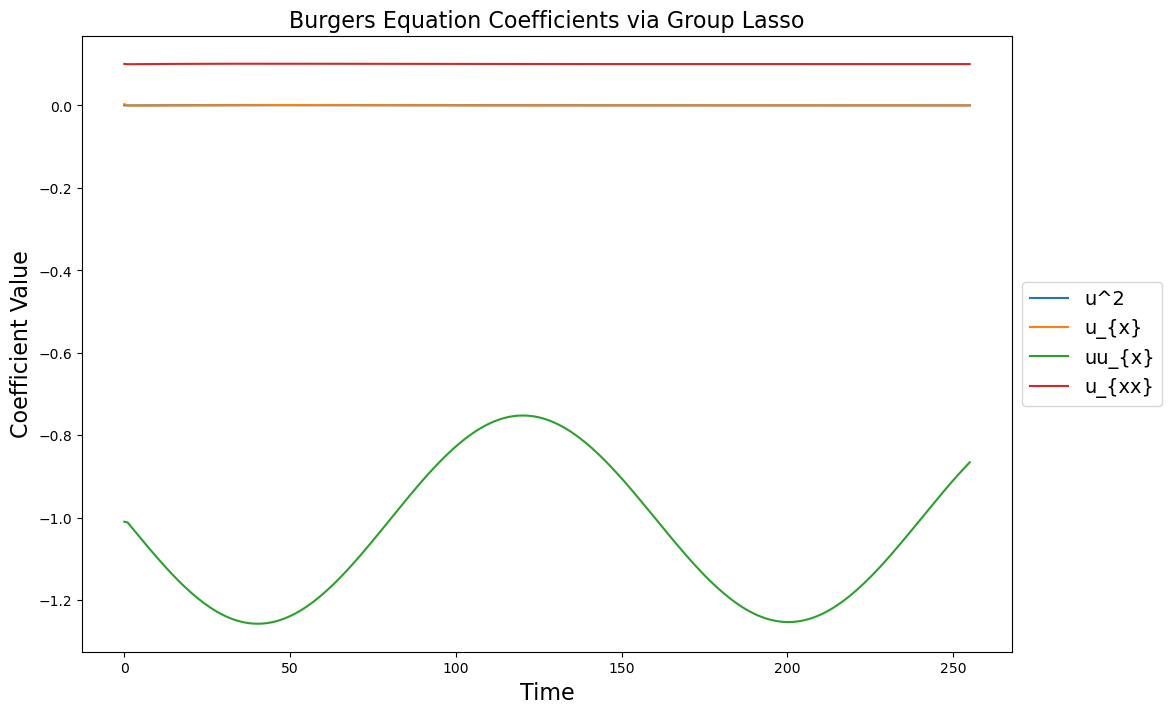

In [9]:
groups = [[j+20*i for i in range(m)] for j in range(20)]

Xi_lasso,Lam_lasso,Losses_lasso,Histories_Lasso = TrainGroupLasso(Theta_grouped, Ut_grouped, groups)
xi_lasso = Xi_lasso[np.argmin(Losses_lasso)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_lasso.shape[0]): 
    if np.linalg.norm(xi_lasso[j,:]) > 10**-10:
        plot(xi_lasso[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients via Group Lasso', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_clean_gl = Norm(xi_lasso-xi_true)**2/(m*16)
print('MSE: ', mse_clean_gl)

In [10]:
un = u + 0.01*std(u)*np.random.randn(n,m)

In [11]:
# Build linear systems
wx = 10 
wt = 10 

Utn, Thetan, rhs_des = build_linear_system(un, dt, dx, D=4, P=3, time_diff = 'poly',
                                       deg_x = 6, deg_t = 4, 
                                       width_x = wx, width_t = wt)
n2 = n - 2*wx
m2 = m - 2*wt

In [12]:
# Group by timestep
Thetan_grouped = [real(Thetan[j*n2:(j+1)*n2,:]) for j in range(m2)]
Utn_grouped = [real(Utn[j*n2:(j+1)*n2]) for j in range(m2)]

/home/yifan/Documents/code_equation_learn/Experiments/parametric_pde_find.py:601: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), normalize)
/home/yifan/Documents/code_equation_learn/Experiments/parametric_pde_find.py:571: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W[biginds,i] = np.linalg.lstsq(Xs[i][:, biginds],ys[i])[0].reshape(len(biginds))


MSE:  3.2336753677008535e-05


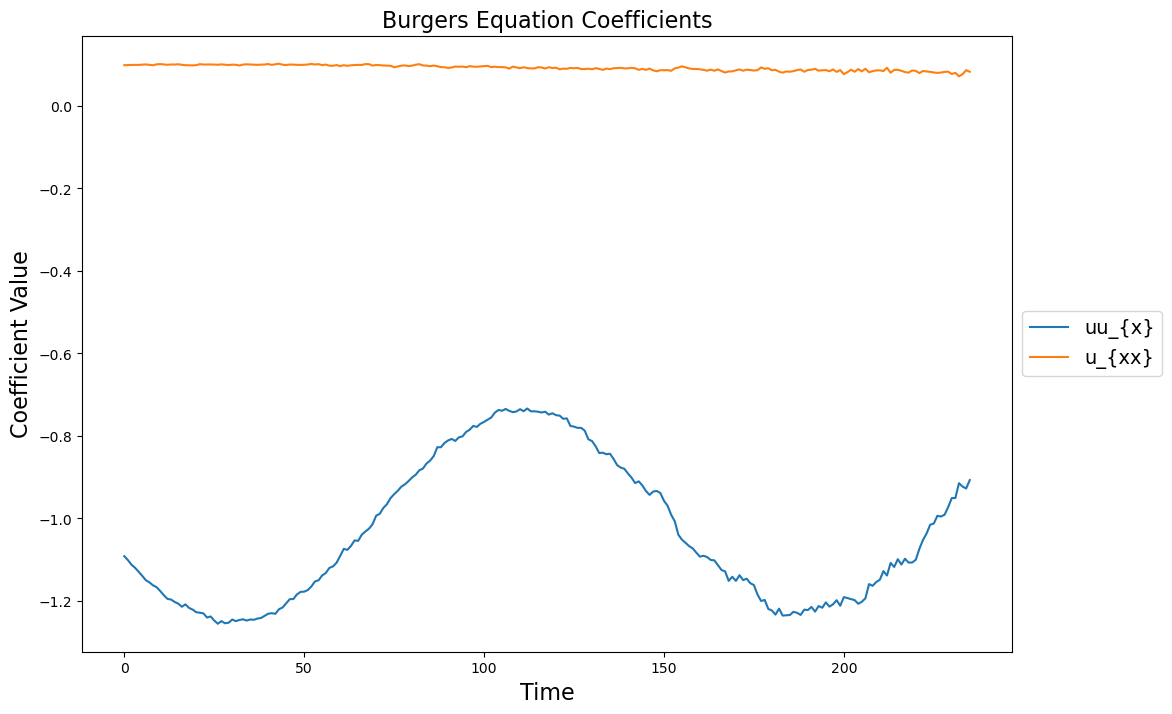

In [13]:
Xi_n,Tol_n,Losses_n = TrainSGTRidge(Thetan_grouped, Utn_grouped)
xi_n = Xi_n[np.argmin(Losses_n)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_n.shape[0]): 
    if np.linalg.norm(xi_n[j,:]) > 10**-10:
        plot(xi_n[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_sgtr = Norm(xi_n-xi_true[:,wt:-wt])**2/(m2*16)
print('MSE: ', mse_noise_sgtr)

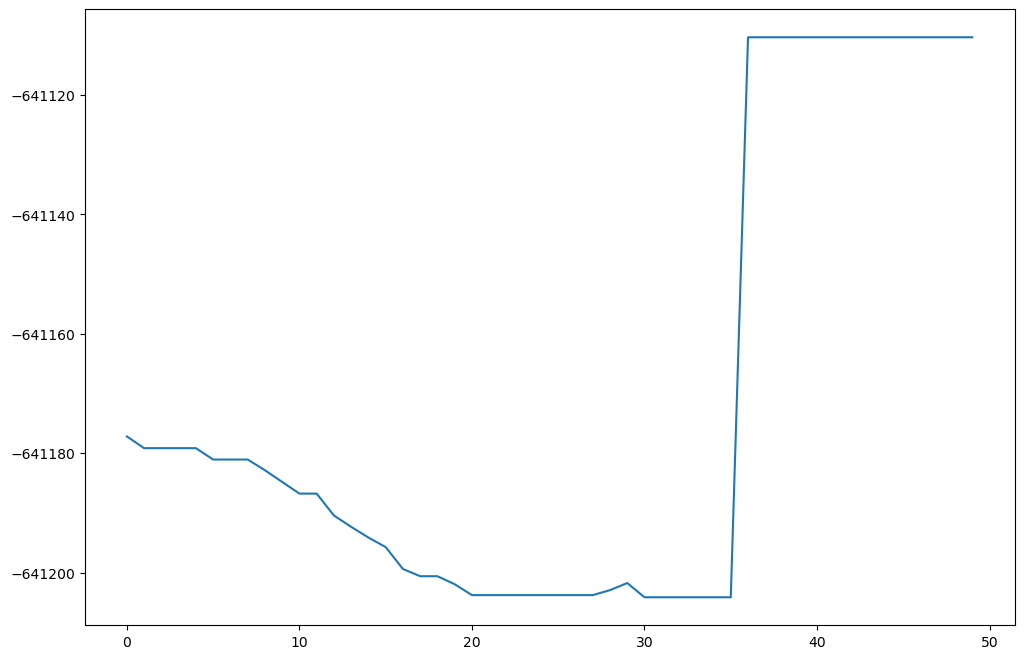

In [14]:
plot(Losses_n)

/home/yifan/Documents/code_equation_learn/Experiments/parametric_pde_find.py:456: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), normalize)
/home/yifan/Documents/code_equation_learn/Experiments/parametric_pde_find.py:436: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  z[nz_coords,j] = np.linalg.lstsq(As[j][:, nz_coords], bs[j])[0][:,0]


MSE:  0.0009976832734132587


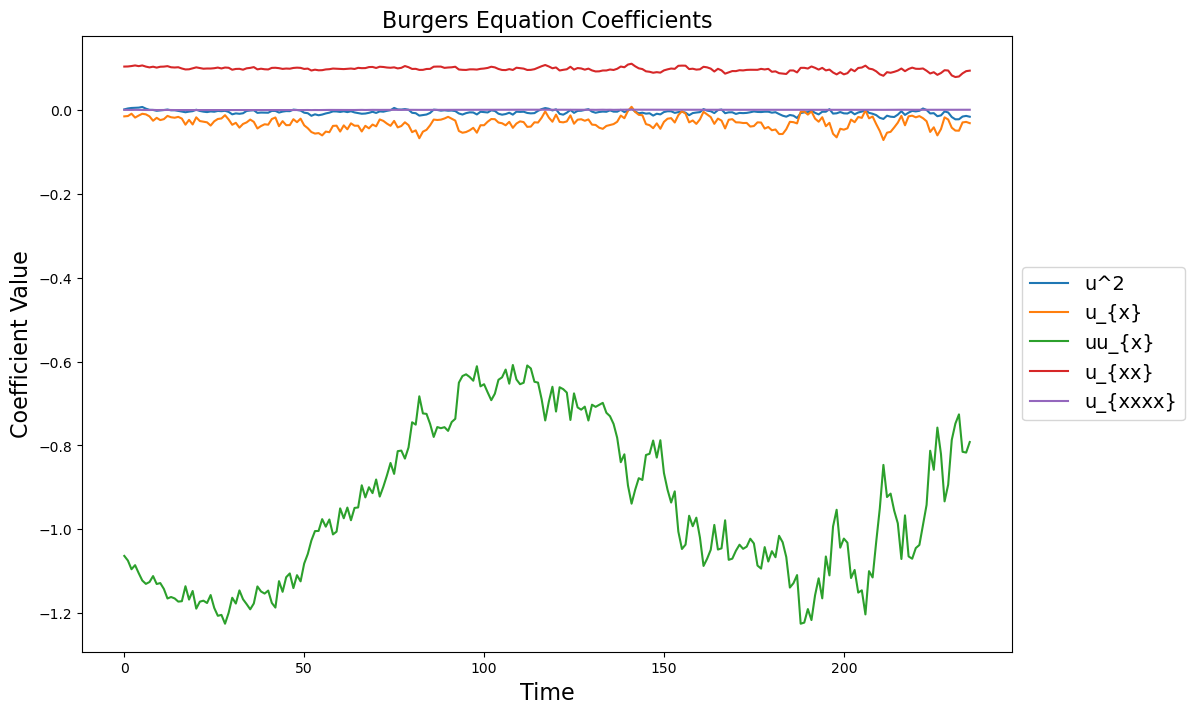

In [15]:
groups = [[j+20*i for i in range(m2)] for j in range(20)]
Xi_lasso_n,Lam_lasso_n,Losses_lasso_n,Histories_Lasso_n  = TrainGroupLasso(Thetan_grouped, Utn_grouped, groups)
xi_lasso_n = Xi_lasso_n[np.argmin(Losses_lasso_n)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_lasso_n.shape[0]): 
    if np.linalg.norm(xi_lasso_n[j,:]) > 10**-10:
        plot(xi_lasso_n[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_gl = Norm(xi_lasso_n-xi_true[:,wt:-wt])**2/(m2*16)
print('MSE: ', mse_noise_gl)

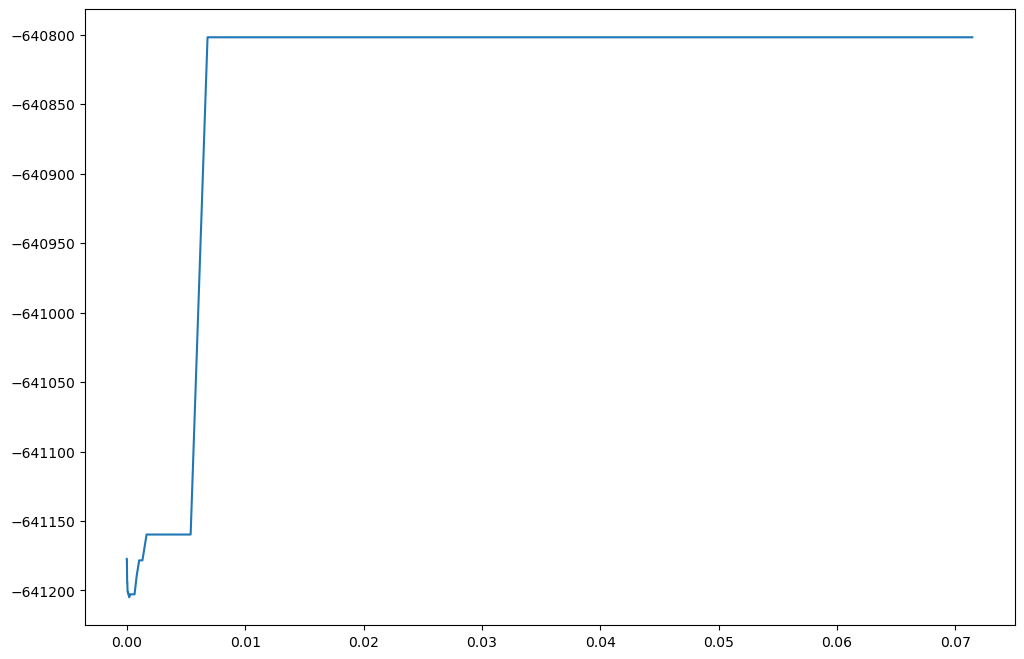

In [16]:
plot(Lam_lasso_n,Losses_lasso_n)

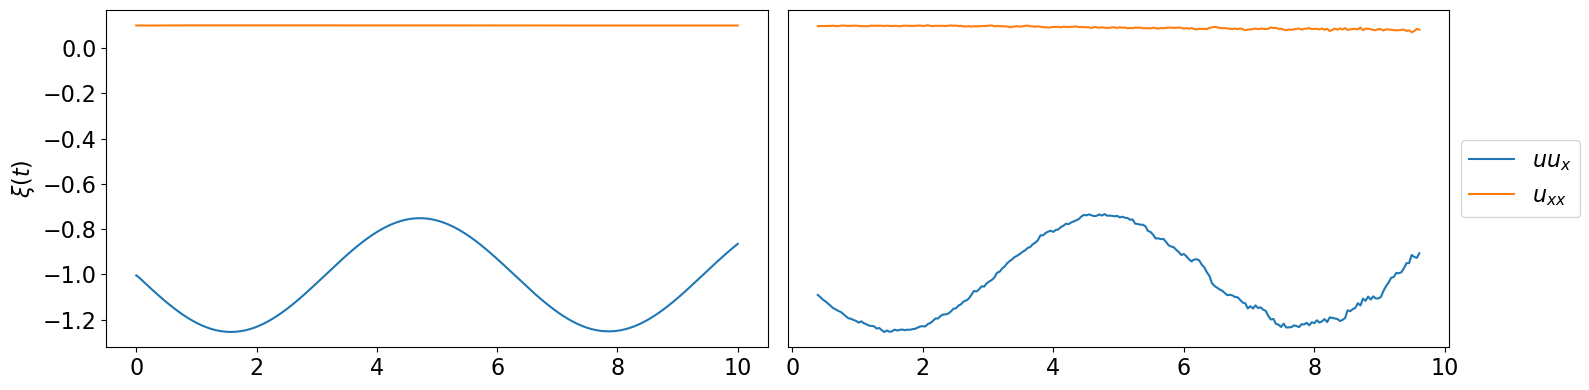

In [17]:
figure(figsize = (16,4))
label_fs = 16

subplot(1,2,1)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        plot(t,xi[j,:], label = rhs_des[j])

ylabel(r'$\xi(t)$', fontsize = 16)
xticks(fontsize = 16)
yticks(fontsize = 16)

subplot(1,2,2)
for j in range(xi_n.shape[0]): 
    if np.linalg.norm(xi_n[j,:]) > 10**-10:
        plot(t[wt:-wt],xi_n[j,:], label = '$'+rhs_des[j]+'$')
        
xticks(fontsize = 16)
yticks([], fontsize = 16)

legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 16)

tight_layout()

(array([-641220., -641200., -641180., -641160., -641140., -641120.,
        -641100.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

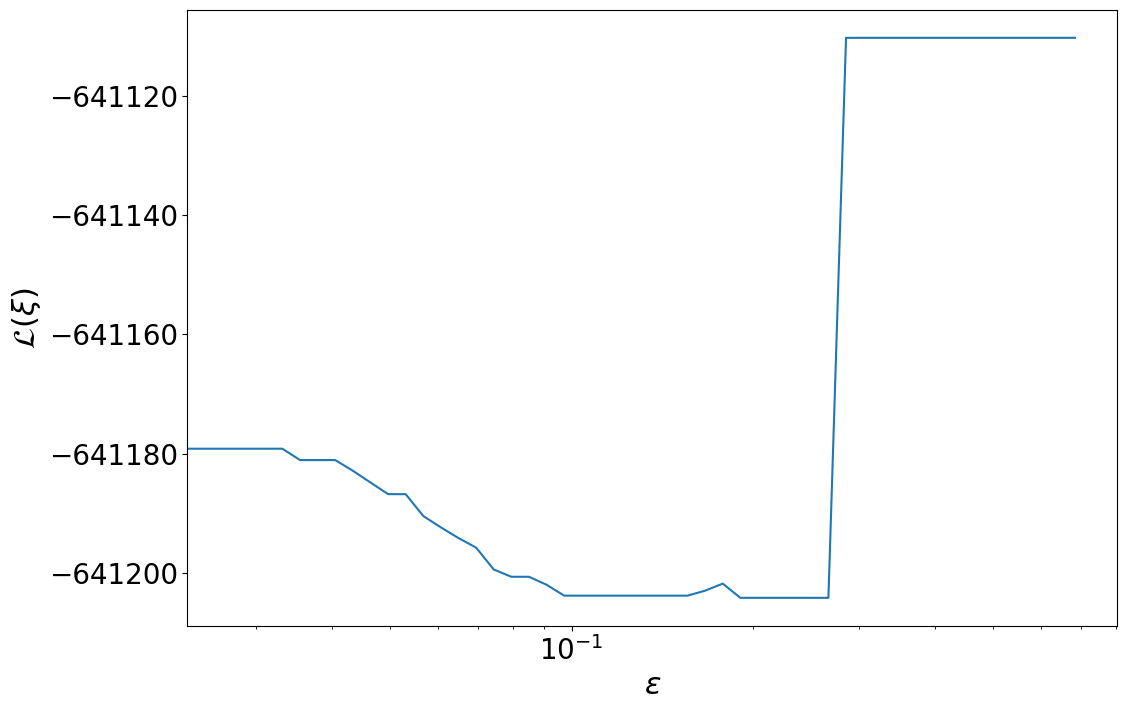

In [18]:
semilogx(Tol_n,Losses_n)
xlabel('$\epsilon$', fontsize = fontsize+2)
ylabel(r'$\mathcal{L}(\xi )$', fontsize = fontsize+2)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

(-641245.2215811976, -640761.457959772)

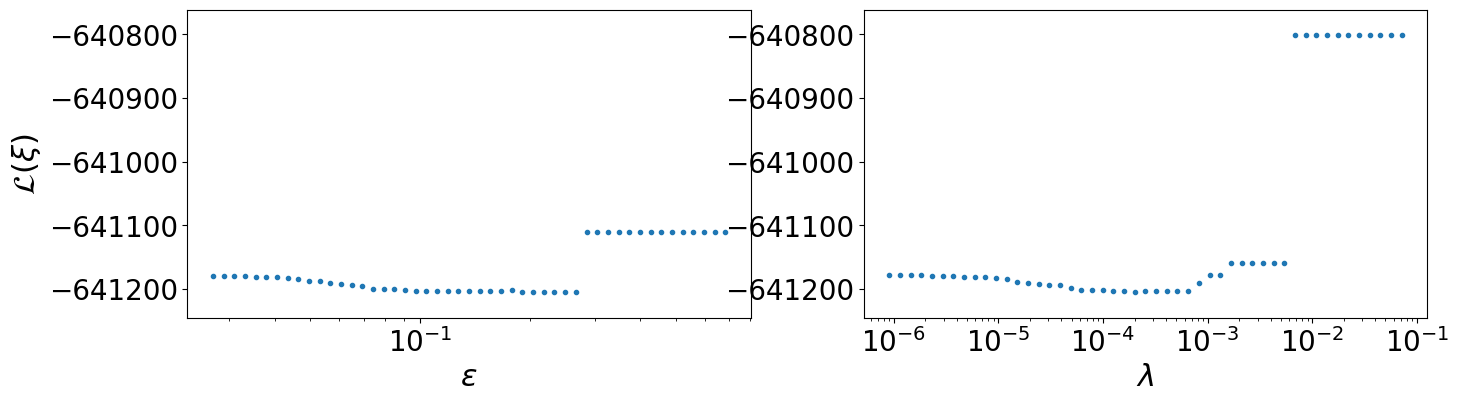

In [19]:
# Plot
fig=figure(figsize=(16,4))

ymin = np.min(Losses_n + Losses_lasso_n)
ymax = np.max(Losses_n + Losses_lasso_n)
loss_range = ymax-ymin
ymax = ymax+0.1*loss_range
ymin = ymin-0.1*loss_range

subplot(1,2,1)
semilogx(Tol_n,Losses_n, '.')
xlabel('$\epsilon$', fontsize = fontsize+2)
ylabel(r'$\mathcal{L}(\xi )$', fontsize = fontsize+2)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
# xlim([Tol_n[0],Tol_n[-1]])
ylim([ymin,ymax])

subplot(1,2,2)
semilogx(Lam_lasso_n,Losses_lasso_n, '.')
xlabel('$\lambda$', fontsize = fontsize+2)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
# xlim([Lam_lasso_n[0],Lam_lasso_n[-1]])
ylim([ymin,ymax])

/tmp/ipykernel_35655/231132893.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  subplot(2,2,1)
/tmp/ipykernel_35655/231132893.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  subplot(2,2,2)
/tmp/ipykernel_35655/231132893.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and retu

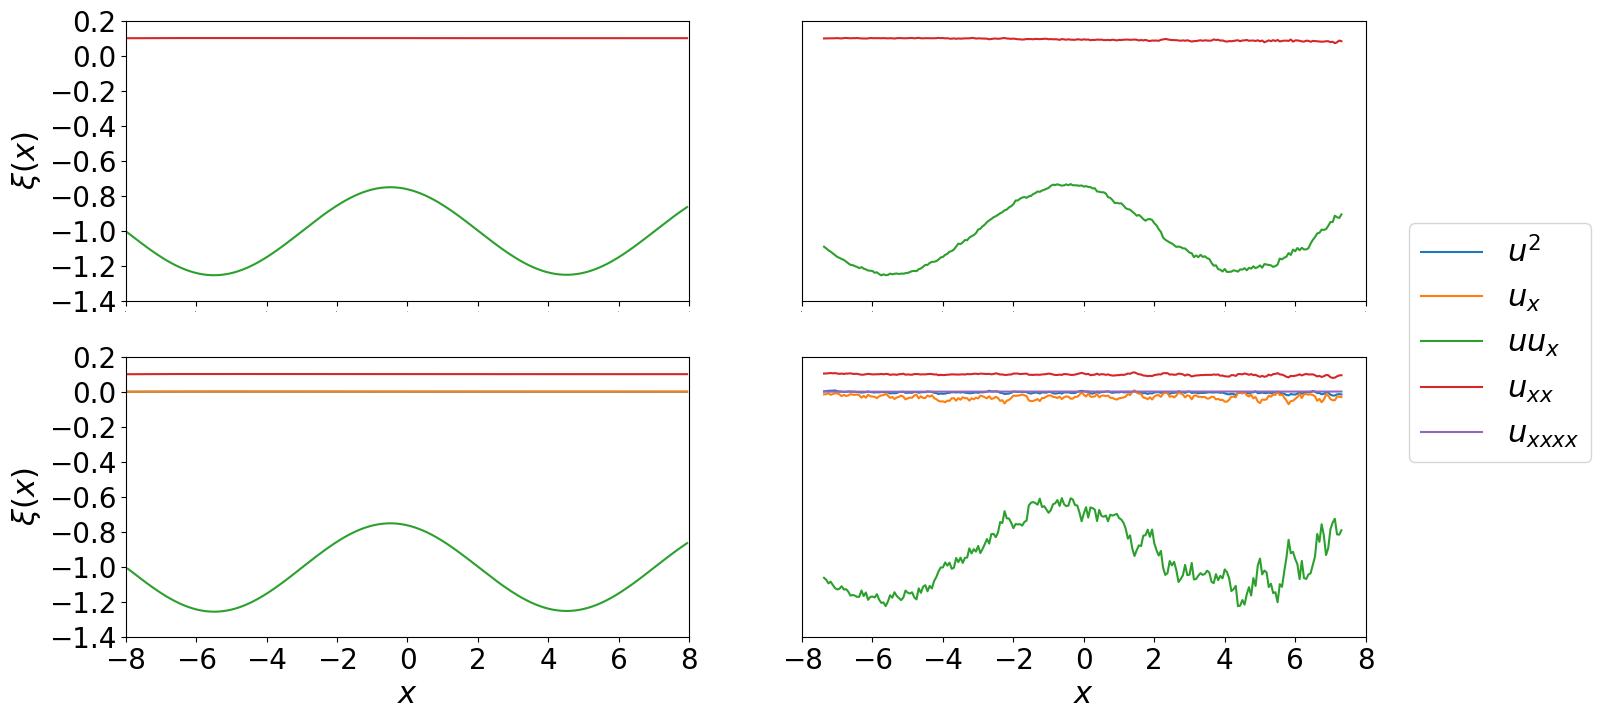

In [20]:
figure(figsize = (16,8))
L = 8

for j in range(xi.shape[0]): 
    
    if np.linalg.norm(xi[j,:]) > 10**-10 or \
       np.linalg.norm(xi_lasso[j,:]) > 10**-10 or \
       np.linalg.norm(xi_n[j,:]) > 10**-10 or \
       np.linalg.norm(xi_lasso_n[j,:]) > 10**-10:
        
        subplot(2,2,1)
        if np.linalg.norm(xi[j,:]) > 10**-10:
            plot(x,xi[j,:], label = rhs_des[j])
        else: plot([-100,-99], [0,0])
            
        subplot(2,2,2)
        if np.linalg.norm(xi_n[j,:]) > 10**-10:
            plot(x[wx:-wx],xi_n[j,:], label = rhs_des[j])
        else: plot([-100,-99], [0,0])
            
        subplot(2,2,3)
        if np.linalg.norm(xi_lasso[j,:]) > 10**-10:
            plot(x,xi_lasso[j,:], label = '$'+rhs_des[j]+'$')
        else: plot([-100,-99], [0,0], label = '$'+rhs_des[j]+'$')
        
        subplot(2,2,4)
        if np.linalg.norm(xi_lasso_n[j,:]) > 10**-10:
            plot(x[wx:-wx],xi_lasso_n[j,:], label = '$'+rhs_des[j]+'$')
        else: plot([-100,-99], [0,0], label = '$'+rhs_des[j]+'$')

subplot(2,2,1); xlim([-L,L]); ylim([-1.4,0.2]); xticks(fontsize = 0); yticks(fontsize = fontsize)
subplot(2,2,2); xlim([-L,L]); ylim([-1.4,0.2]); xticks(fontsize = 0); yticks([])
subplot(2,2,3); xlim([-L,L]); ylim([-1.4,0.2]); xticks(fontsize = fontsize); yticks(fontsize = fontsize); xlabel(r'$x$', fontsize = fontsize+2)
subplot(2,2,4); xlim([-L,L]); ylim([-1.4,0.2]); xticks(fontsize = fontsize); yticks([]); xlabel(r'$x$', fontsize = fontsize+2)

subplot(2,2,1); ylabel(r'$\xi(x)$', fontsize = fontsize+2)
subplot(2,2,3); ylabel(r'$\xi(x)$', fontsize = fontsize+2)
subplot(2,2,4); legend(loc='center left', bbox_to_anchor=(1.05, 1.05), fontsize = fontsize+2)

# tight_layout()